<a href="https://colab.research.google.com/github/jamiroquai1225/NLP/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
papers = pd.read_excel('wos.xlsx')
documents = papers['abs']
len(documents)

1017

In [ ]:
# Load the regular expression library
import re
# Remove punctuation
papers['paper_text_processed'] = papers['abs'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers

In [ ]:
pip install gensim

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['ireland', 'is', 'the', 'most', 'trade', 'dependent', 'country', 'in', 'the', 'european', 'union', 'as', 'peripheral', 'island', 'economy', 'an', 'effective', 'seaport', 'system', 'is', 'essential', 'to', 'link', 'into', 'international', 'trade', 'and', 'facilitate', 'export', 'led']


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['result', 'use', 'also', 'analyze', 'use', 'study', 'research','analysis','paper','purpose'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
!python3 -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 8.2 MB/s eta 0:00:00 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['trade', 'dependent', 'country', 'european_union', 'peripheral', 'island', 'economy', 'effective', 'seaport', 'system', 'international', 'export', 'lead', 'development', 'growth', 'maritime', 'trade', 'disperse', 'benefit', 'port', 'recently', 'traffic', 'polarise', 'strongly', 'port', 'cork', 'waterford', 'process', 'play', 'key', 'role', 'change', 'comparative', 'advantage', 'irish', 'port', 'stimulate', 'trade', 'deflection', 'trade', 'port', 'europeanisation', 'globalisation', 'industrial', 'policy', 'economic', 'restructuring', 'peripherality', 'transport', 'policy', 'development', 'plan', 'structural', 'fund', 'reduce', 'cost', 'peripherality', 'foc', 'investment', 'strategic', 'national', 'port', 'service', 'corridor', 'trade', 'irish', 'sea', 'new', 'context', 'port', 'management', 'create', 'act']]


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 2), (42, 6), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 5), (57, 1), (58, 1), (59, 1)]]


In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.043*"port" + 0.013*"service" + 0.010*"location" + 0.008*"cargo" + '
  '0.008*"transport" + 0.006*"flow" + 0.006*"development" + 0.005*"economic" + '
  '0.005*"market" + 0.005*"model"'),
 (1,
  '0.026*"container" + 0.020*"port" + 0.019*"model" + 0.018*"problem" + '
  '0.012*"terminal" + 0.011*"time" + 0.009*"propose" + 0.007*"service" + '
  '0.007*"vessel" + 0.007*"method"'),
 (2,
  '0.026*"port" + 0.017*"logistic" + 0.014*"development" + 0.012*"economic" + '
  '0.012*"seaport" + 0.010*"transport" + 0.008*"industry" + 0.006*"regional" + '
  '0.006*"infrastructure" + 0.006*"country"'),
 (3,
  '0.045*"port" + 0.013*"model" + 0.012*"cost" + 0.010*"container" + '
  '0.008*"transport" + 0.007*"terminal" + 0.007*"efficiency" + 0.006*"result" '
  '+ 0.006*"transportation" + 0.006*"performance"'),
 (4,
  '0.020*"port" + 0.012*"maritime" + 0.011*"integration" + 0.010*"shipping" + '
  '0.007*"canal" + 0.007*"free_trade" + 0.007*"ship" + 0.007*"zone" + '
  '0.007*"system" + 0.007*"strate

In [ ]:
pip install pyLDAvis

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 7.4 MB/s eta 0:00:00 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 5.4 MB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pyLDAvis.gensim_models
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.082972  0.010368       1        1  26.613012
2      0.020568 -0.126654       2        1  21.919558
1     -0.116771  0.123525       3        1  21.724341
5     -0.019665 -0.088925       4        1  17.073732
0      0.006715 -0.002411       5        1   8.063343
4      0.192124  0.084096       6        1   4.606013, topic_info=             Term         Freq        Total Category  logprob  loglift
42           port  2901.000000  2901.000000  Default  30.0000  30.0000
476     container   753.000000   753.000000  Default  29.0000  29.0000
211       problem   395.000000   395.000000  Default  28.0000  28.0000
1089         risk   188.000000   188.000000  Default  27.0000  27.0000
500      terminal   385.000000   385.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
608           hub    14.650399   110.436659   Topic6  -5.5892   1.0578
13    development    15.631714   474.091147   Topic6  -5.5243  -0.3343
43        process    14.746897   208.398980   Topic6  -5.5826   0.4294
58      transport    15.145819   529.141461   Topic6  -5.5559  -0.4757
238       develop    14.643207   315.083661   Topic6  -5.5896   0.0089

[464 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
836       2  0.569018    academic
836       4  0.087541    academic
836       6  0.350165    academic
1290      3  0.891530  accelerate
4247      5  0.770794    actively
...     ...       ...         ...
524       3  0.986734        yard
611       1  0.017942        zone
611       2  0.466501        zone
611       3  0.035885        zone
611       6  0.484443        zone

[1032 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 6, 1, 5])

In [ ]:
import pyLDAvis.gensim as gensimvis
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_prepared_html')

In [ ]:
# Hyperparameter tuning

In [ ]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.4394854533195565

Coherence Score:  0.3410241300874341


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=10, step=1)

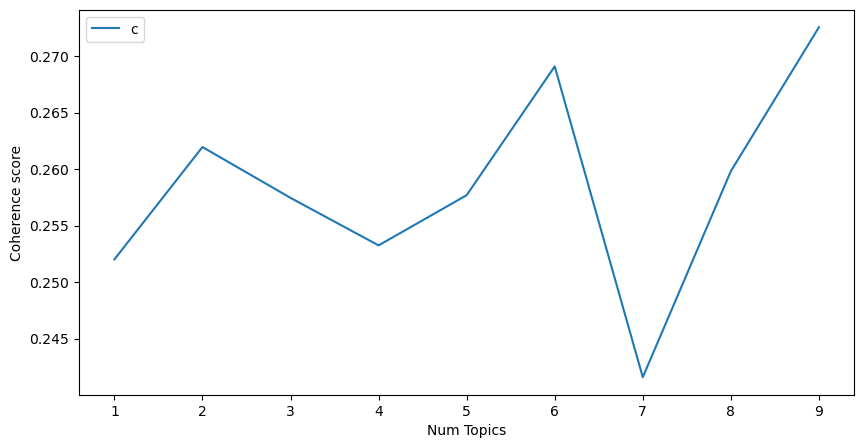

In [ ]:
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.figure(figsize=(10,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()